<a id='Top'></a>

# WSIPRE - <u>W</u>hole-<u>S</u>lide <u>I</u>mage <u>PRE</u>processing<a class='tocSkip'></a>

## Package demo<a class='tocSkip'></a>

Install wsipre.

In [1]:
!pip install wsipre

In [1]:
# Load source code changes in real time
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from wsipre import slide, show

Make sure [OpenSlide](https://openslide.org/) version 3.4.1 is installed.

In [2]:
import openslide
print('OpenSlide version', openslide.__library_version__)

OpenSlide version 3.4.1


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-and-displaying-WSIs" data-toc-modified-id="Loading-and-displaying-WSIs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading and displaying WSIs</a></span><ul class="toc-item"><li><span><a href="#Annotated-WSIs" data-toc-modified-id="Annotated-WSIs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Annotated WSIs</a></span></li><li><span><a href="#WSIs-without-annotations" data-toc-modified-id="WSIs-without-annotations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>WSIs without annotations</a></span></li></ul></li><li><span><a href="#Locating-tissue-in-WSI" data-toc-modified-id="Locating-tissue-in-WSI-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Locating tissue in WSI</a></span></li><li><span><a href="#Sampling-patches-from-WSI" data-toc-modified-id="Sampling-patches-from-WSI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sampling patches from WSI</a></span></li></ul></div>

# Loading and displaying WSIs

Start by defining some example whole-slide images (WSIs), as well as some colors for visualization.

In [3]:
wsi_files = ('tumor_001.tif',
             'tumor_001.xml')

In [4]:
black = (0, 0, 0)
red = (1, 0, 0)
yellow = (1, 1, 0)

## Annotated WSIs

Load an WSI with its lesion-level annotation using the `Slide` class.

In [5]:
xml_annotation_style = 'asap'
slide_file, annotation_file = wsi_files

wsi = slide.Slide(
    filename=slide_file,
    annotation_filename=annotation_file,
    xml_style=xml_annotation_style)

Generate a thumbnail of the whole slide for visualization.

In [6]:
thumbnail, mask, downsampling_factor = wsi.get_thumbnail_with_annotation(
    size=(3000, 3000), polygon_type='line', line_thickness=8)

Next we display the thumbnail and respective annotation side-by-side. First check what labels are present, to assign a color to each label, using the attribute `label_map`.

In [7]:
wsi.label_map

{'_0': 2, '_1': 2, '_2': 1}

Only label `2` is present in the annotations. Additionally, __label `0` is the default for non-annotated regions__. So we need to define a mapping of each one of labels `0` and `2` to a color.

Visualization of WSIs and their regions is handled by the `Figure` class.

In [8]:
colors = {0: black, 2: red}

fig = show.Figure(image=thumbnail, annotation=mask, color_map=colors)

The defined `color_map` is now accessible as a `Figure` instance attribute.

In [9]:
fig.color_map

{0: (0, 0, 0), 2: (1, 0, 0)}

The `Figure` class also provides a convenience method to display a legend of label colors.

In [10]:
plt.rcParams['figure.figsize'] = (3, 3)

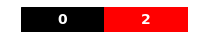

In [11]:
fig.show_label_colors()

Finally, let's display the figure and the annotation split side-by-side.

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)

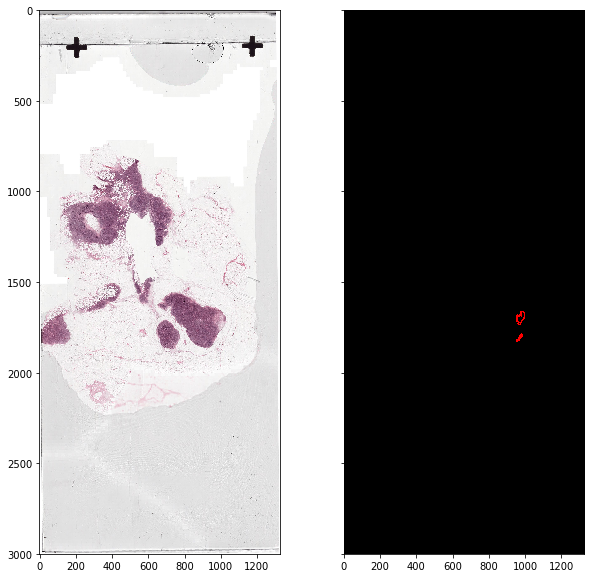

In [13]:
fig.show_image_with_annotation()

Alternatively, the annotations can be overlaid on the image.

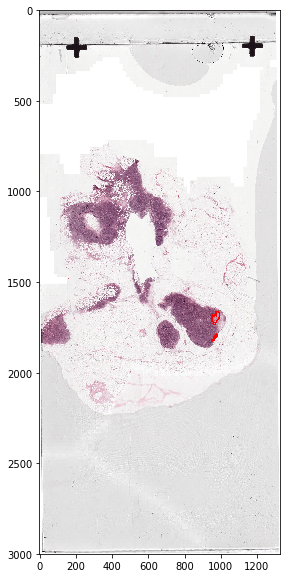

In [14]:
fig.show_image_with_annotation(split=False)

Standard `OpenSlide` methods and attributes remain accessible in `Slide` instances. Here are some examples.

In [15]:
wsi.level_count

10

In [16]:
wsi.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

In [17]:
wsi.level_dimensions

((97792, 221184),
 (48896, 110592),
 (24448, 55296),
 (12224, 27648),
 (6112, 13824),
 (3056, 6912),
 (1528, 3456),
 (764, 1728),
 (382, 864),
 (191, 432))

The previous output illustrates how large WSIs can be. In the highest resolution level (level 0) this particular WSI is 97'792 x 221'184 pixels large (that's a total of 21'630'025'728 pixels, __over 21 Gigapixels!__).

Let's now read a small region from the WSI. Looking at the thumbnail displayed above, the annotations appear around position `(1000, 1700)` in the down-scaled thumbnail. We can use that to try to read a region including annotations, after some trial and error to find a good framing.

> __Note 1:__ The __wsipre__ API, just like OpenSlide Python's, always expects coordinates in the highest resolution level (level 0). In this example, we need to use the `downsampling_factor` returned when generating the thumbnail above to scale the coordinates up.

> __Note 2:__ The `downsampling_factor` also refers to level 0 and, naturally, the thumbnail coordinates scaled up by the `downsampling_factor` are the original coordinates on level zero. When sampling from a higher level (as in the next cell) the coordinates will not match perfectly.

In [18]:
loc = (int(850*downsampling_factor), int(1640*downsampling_factor))

slide_region, mask_region = wsi.read_region_with_annotation(
    location=loc, level=4, size=(1000, 1000), polygon_type='line', line_thickness=5)

We can now display the image region and the annotation, wither split or overlaid.

Let's first check the `label_map` to make sure we assign colors to all labels.

In [19]:
wsi.label_map

{'_0': 2, '_1': 2, '_2': 1}

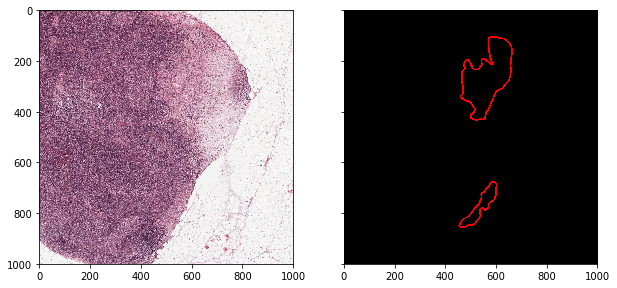

In [20]:
plt.rcParams['figure.figsize'] = (10, 10)

fig = show.Figure(slide_region, mask_region, colors)
fig.show_image_with_annotation()

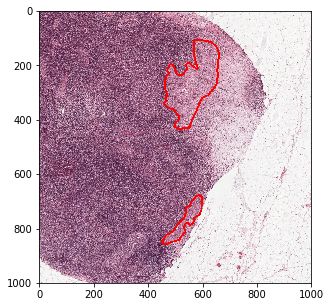

In [21]:
plt.rcParams['figure.figsize'] = (5, 5)

fig.show_image_with_annotation(split=False)

If we didn't need the annotation, we could also simply use `OpenSlide`'s `read_region` method to read the same region.

In [22]:
loc = (int(850*downsampling_factor), int(1640*downsampling_factor))

slide_region = wsi.read_region(location=loc, level=4, size=(1000, 1000))

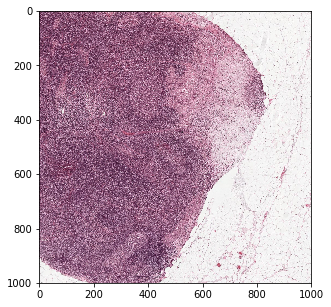

In [23]:
plt.rcParams['figure.figsize'] = (5, 5)

plt.imshow(slide_region)

## WSIs without annotations

You can also load an WSI without annotations. Again, all OpenSlide Python functionality is used through its standard API.

In [24]:
slide_file, annotation_file = wsi_files

wsi = slide.Slide(filename=slide_file)

In [25]:
thumbnail = wsi.get_thumbnail(size=(3000, 3000))

We can display images using Matplotlib.

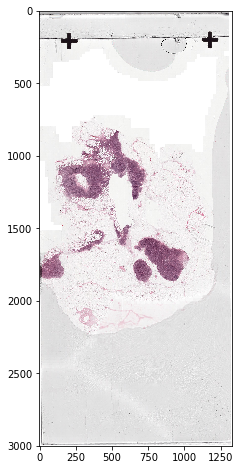

In [26]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.imshow(thumbnail)

In [27]:
loc = (int(850*downsampling_factor), int(1640*downsampling_factor))

slide_region = wsi.read_region(location=loc, level=4, size=(1000, 1000))

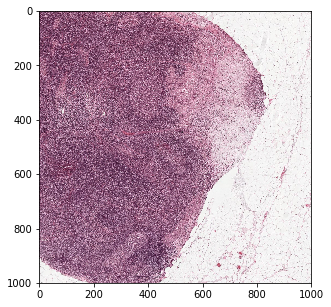

In [28]:
plt.rcParams['figure.figsize'] = (5, 5)

plt.imshow(slide_region)

# Locating tissue in WSI

A basic task is to generate regions of interest (RoI) in the large WSIs annotating tissue versus background. __wsipre__ provides a built-in option to generate tissue RoIs.

In [29]:
xml_annotation_style = 'asap'
slide_file, annotation_file = wsi_files

wsi = slide.Slide(
    filename=slide_file,
    annotation_filename=annotation_file,
    xml_style=xml_annotation_style)

In [30]:
wsi.get_tissue_mask()

Slide('/home/luis/Desktop/slides/tumor_001.tif')

When generating the tissue RoIs, a `tissue_label_map` is also created.

In [31]:
wsi.tissue_label_map

{'background': 0, 'tissue': 1}

We can now treat this as an annotation and repeat the procedure illustrated above.

> __Note:__ Colors in the provided `color_map` can also be defined using the 0-255 range. The `Figure` class will automatically scale them down to the 0-1 range.

In [32]:
fig = show.Figure(image=wsi.downsampled_slide, annotation=wsi.tissue_mask,
                  color_map={0: [0, 0, 0], 1: [255, 255, 255]})

In [33]:
fig.color_map

{0: [0.0, 0.0, 0.0], 1: [1.0, 1.0, 1.0]}

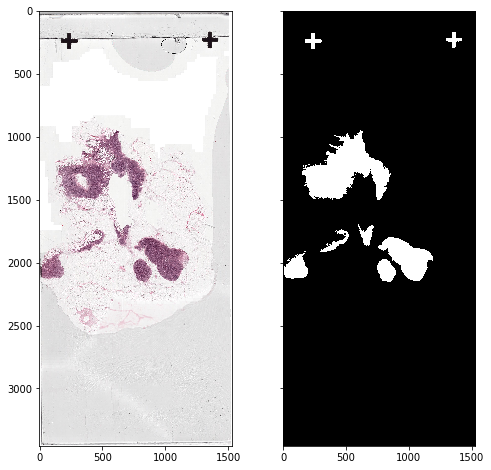

In [34]:
plt.rcParams['figure.figsize'] = (8, 8)

fig.show_image_with_annotation()

When plotting the tissue mask overlaid on the WSI thumbnail, it works better if the tissue mask is generated using contour lines rather than filled areas. The following cells illustrate that procedure.

In [35]:
wsi.get_tissue_mask(polygon_type='line', line_thickness=8)

Slide('/home/luis/Desktop/slides/tumor_001.tif')

In [36]:
wsi.tissue_label_map

{'background': 0, 'tissue': 1}

In [37]:
fig = show.Figure(wsi.downsampled_slide, wsi.tissue_mask, {0: black, 1: yellow})

fig.color_map

{0: (0, 0, 0), 1: (1, 1, 0)}

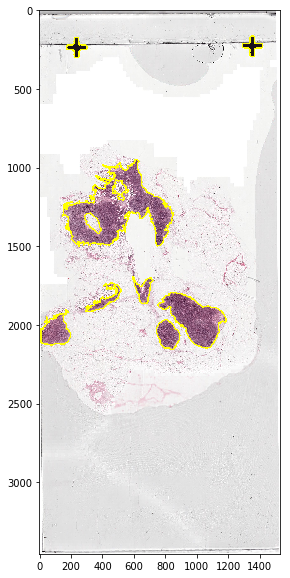

In [38]:
plt.rcParams['figure.figsize'] = (10, 10)

fig.show_image_with_annotation(split=False)

# Sampling patches from WSI

Due to the large size of WSIs, ML applications use smaller image patches sampled from the WSI. __wsipre__ offers some basic random patch sampling functionality, guided by tissue RoIs and/or provided annotations.

In [39]:
xml_annotation_style = 'asap'
slide_file, annotation_file = wsi_files

wsi = slide.Slide(
    filename=slide_file,
    annotation_filename=annotation_file,
    xml_style=xml_annotation_style)

In [40]:
thumbnail, mask, downsampling_factor = wsi.get_thumbnail_with_annotation(
    size=(3000, 3000), polygon_type='line', line_thickness=5)

wsi.label_map

{'_0': 2, '_1': 2, '_2': 1}

In [41]:
plt.rcParams['figure.figsize'] = (10, 10)

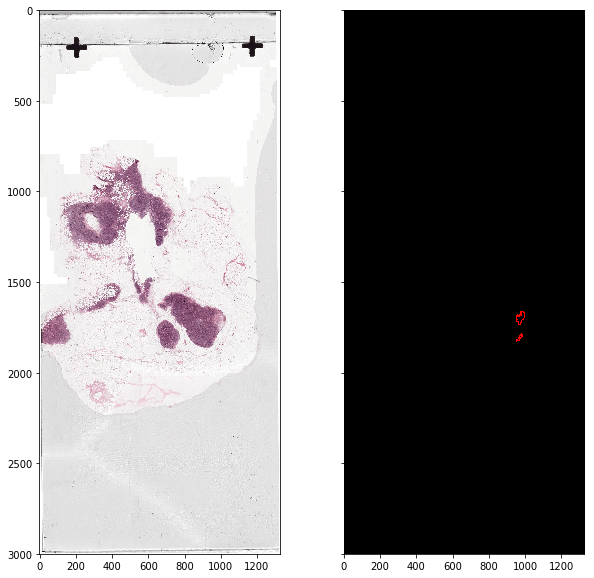

In [42]:
fig = show.Figure(thumbnail, mask, {0: black, 2: red})
fig.show_image_with_annotation()

We can sample from the tissue RoI using `read_random_tissue_patch`, __ignoring__ any other available annotations.

> __Note:__ A simple thresholding of the proportion of pixels in the returned patch that have the same value (set to a maximum of 50%) avoids patches from false positive regions (for example the black plus sign-shaped areas in this slide).

In [43]:
plt.rcParams['figure.figsize'] = (5, 5)

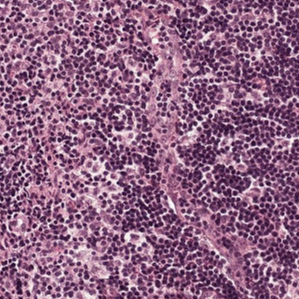

In [44]:
wsi.read_random_tissue_patch(level=2, size=(299, 299))

If the target is tissue that not otherwise labeled in the provided annotation (in this example, sample from normal tissue, __not__ tumor tissue), we can pass in an explicit collection of labels to avoid.

Let's first check again what labels are available.

In [45]:
wsi.label_map

{'_0': 2, '_1': 2, '_2': 1}

We want to sample normal tissue, avoiding label `2`.

In [46]:
plt.rcParams['figure.figsize'] = (10, 10)

In [47]:
image, mask = wsi.read_random_tissue_patch(level=2, size=(299, 299), avoid_labels=[2])

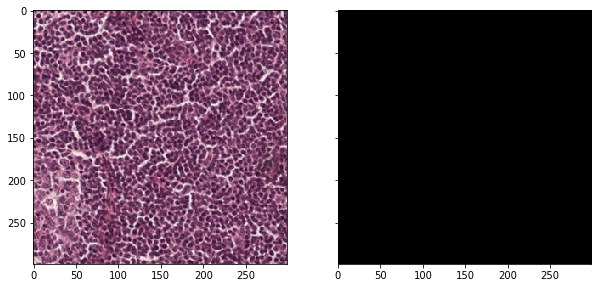

In [48]:
fig = show.Figure(image, mask, {0: black, 2: red})
fig.show_image_with_annotation()

We can also sample from a selected target class. Let's check available class labels and then use one to sample patches from.

Let's use a lower resolution level (slide level 2) and plot the annotation as a line overlaid on the image patch.

In [51]:
slide_region, mask_region = wsi.read_random_patch(
    level=2, size=(299, 299), target_class=2,
    min_class_area_ratio=0.75,
    polygon_type='line', line_thickness=2)

fig = show.Figure(slide_region, mask_region, {0: black, 2:red})

fig.color_map

{0: (0, 0, 0), 2: (1, 0, 0)}

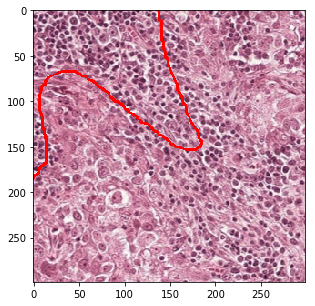

In [52]:
plt.rcParams['figure.figsize'] = (5, 5)

fig.show_image_with_annotation(split=False)

[Top of the page](#Top)